In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sklearn pipelines
from sklearn.pipeline import Pipeline

# A few classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# available list of all classifiers https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

#prerprocessing 
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# combinatory techniques
from sklearn.ensemble import VotingClassifier

# hyperparameter
from sklearn.utils.fixes import loguniform
from scipy import stats


# grid and randomized searches
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.calibration import CalibratedClassifierCV

In [2]:
from utils.samplegenerator import UserDataGenerator

# Generating and testing the data

In [3]:
# unbalanced label distribution 
label_frequency=[0.1,0.2,0.1,0.5,0.1]
colnames=['click_a','click_b','click_c','click_d','click_e','click_f','amount','purchased_stock','response_time','more_chi_square','retrieved'],
column_types=['binom','binom','binom','binom','binom','binom','binom','norm','categorical','chisquare','chisquare','norm'], 
n_labels=5

preset_spread = 60

print(len(colnames) == len(column_types) )          

True


In [4]:
ug2 = UserDataGenerator(n_labels=n_labels, label_frequency=label_frequency, preset_spread=preset_spread)

    

In [5]:
# Generate Data
%time train_data = ug2.generate_user_df(10000)
test_data = ug2.generate_user_df(5000)

CPU times: user 11.6 s, sys: 215 µs, total: 11.6 s
Wall time: 11.6 s


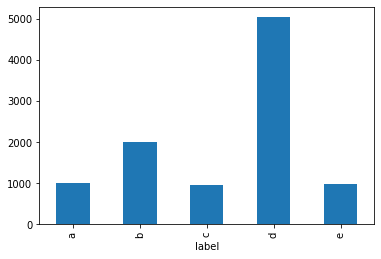

In [6]:
# Distribution plot
ax = train_data.groupby('label').size().plot(kind='bar') # overrepresenting label d
ax.set_label('Verteilung der Klassen')

In [7]:
train_data.columns

Index(['label', 'click_a', 'click_b', 'amount', 'purchased_stock',
       'response_time', 'retrieved'],
      dtype='object')

In [8]:
# transfer categorical to one hot

# transfer categorical to one hot
def to_one_hot(data, categorical_cols):
    """
    extract categorical columns and change them to one hot encoding
    
    IN:
    dataframe Pd.df
    
    OUT:
    dataframe without labels
    label column
    
    
    """
    
    y_train = data['label']
    X_train = data[data.columns.tolist()[1:]]
    
    for element in categorical_cols:
        
        columns = X_train.columns.tolist()
        
        columns.remove(element)
        onehot_purchase = pd.get_dummies(X_train[element] )
        
        # adapt the default names
        newnames = { n : 'el'+ n for n in onehot_purchase.columns.tolist() }
        onehot_purchase.rename(newnames, axis='columns')
    
        
        X_train = pd.concat( [ X_train[columns],onehot_purchase ] 
                    , axis = 1)

    return X_train, y_train


x_train , y_train = to_one_hot(train_data, ['purchased_stock'] )
x_test , y_test = to_one_hot(test_data, ['purchased_stock'] )

In [9]:
# Try Randomforest
rfc = RandomForestClassifier(oob_score=True)
rfc.fit(X=x_train, y=y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
# out of bag estimate
print(f'The out of bag estimate performance is {rfc.oob_score_}')

The out of bag estimate performance is 0.8328


In [11]:
# test _ score
print(f'The validation set score is {rfc.score(x_test, y_test )}')

The validation set score is 0.8304


In [12]:
y_pred = rfc.predict(x_test)
y_true = np.asarray(y_test)
c_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

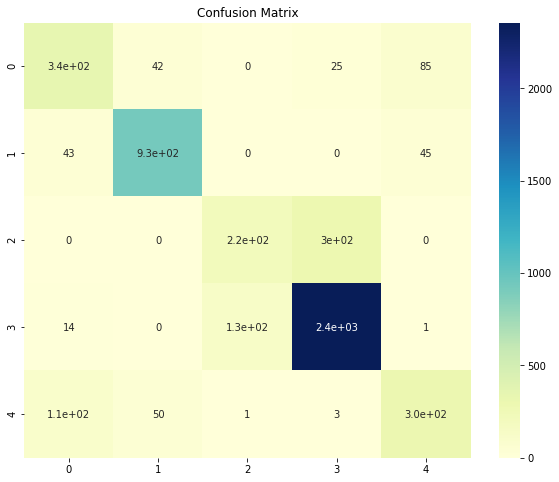

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(c_mat, annot=True, cmap="YlGnBu",ax=ax)
ax.set_title('Confusion Matrix')

In [14]:
# Set of basic algorithms implemented in sklearn

rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc  = GradientBoostingClassifier()
lsvc = LinearSVC(max_iter=2000)
svc  = NuSVC(0.2)
gnbc = GaussianNB()
mlpc = MLPClassifier(max_iter=1000)

classifiers = [("Randomforest",rfc),
               ("AdaBoostClassifier",ada),
               ("Gradientboosting",gbc),
               ("LinearSVC",lsvc),
               ("SVC" ,svc),
               ("GaussianNB", gnbc),
               ("MLPClassifier", mlpc) ]

In [15]:
# simple comparison
for name, classifier in classifiers:
    classifier.fit(X=x_train, y=y_train)
    print(f"Algorithmus {name} : validation score of {classifier.score(x_test, y_test )}" )

Algorithmus Randomforest : validation score of 0.8316
Algorithmus AdaBoostClassifier : validation score of 0.4604
Algorithmus Gradientboosting : validation score of 0.8446


/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Algorithmus LinearSVC : validation score of 0.7484
Algorithmus SVC : validation score of 0.6682
Algorithmus GaussianNB : validation score of 0.8134
Algorithmus MLPClassifier : validation score of 0.8182


# Basic preprocessing

In [16]:
# add scaler
stdscaler = StandardScaler()

In [17]:
# fit on train data
stdscaler.fit(x_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
X_train_scaled = stdscaler.transform(x_train)
x_test_scaled = stdscaler.transform(x_test)

In [19]:
# add crossvalidation to the classifier

for (name, classifier) in classifiers:
    classifier.fit(X=X_train_scaled, y=y_train)
    print(f""" Algorithmus {name} 
                : validation score of {classifier.score(x_test_scaled, y_test )} 
                : crossvalidation score {cross_val_score(classifier, X=X_train_scaled, y=y_train).mean()}""" )

 Algorithmus Randomforest 
                : validation score of 0.831 
                : crossvalidation score 0.835
 Algorithmus AdaBoostClassifier 
                : validation score of 0.4604 
                : crossvalidation score 0.5037
 Algorithmus Gradientboosting 
                : validation score of 0.8444 
                : crossvalidation score 0.8441999999999998
 Algorithmus LinearSVC 
                : validation score of 0.811 
                : crossvalidation score 0.8202
 Algorithmus SVC 
                : validation score of 0.8014 
                : crossvalidation score 0.8108000000000001
 Algorithmus GaussianNB 
                : validation score of 0.8134 
                : crossvalidation score 0.8153
 Algorithmus MLPClassifier 
                : validation score of 0.8474 
                : crossvalidation score 0.8462999999999999


In [20]:
voting = VotingClassifier(estimators= classifiers, voting='hard')
voting.fit(X=X_train_scaled, y=y_train)

VotingClassifier(estimators=[('Randomforest',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0

In [22]:
voting.score(x_test_scaled, y_test )

0.847

In [23]:
# keep only the best 3 classifiers:
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc  = GradientBoostingClassifier()
lsvc = LinearSVC(max_iter=2000)
svc  = NuSVC(0.2)
gnbc = GaussianNB()
mlpc = MLPClassifier(max_iter=1000)

classifiers = [("Randomforest",rfc),
               #("AdaBoostClassifier",ada),
               ("Gradientboosting",gbc),
               #("LinearSVC",lsvc),
               #("SVC" ,svc),
               #("GaussianNB", gnbc),
               ("MLPClassifier", mlpc) ]

In [24]:
voting = VotingClassifier(estimators= classifiers, voting='hard')
voting.fit(X=X_train_scaled, y=y_train)
voting.score(x_test_scaled, y_test )

0.8476

In [25]:
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc  = GradientBoostingClassifier()
#lsvc = LinearSVC(max_iter=2000)
svc  = NuSVC(0.2,probability=True)
gnbc = GaussianNB()
mlpc = MLPClassifier(max_iter=1000)

classifiers = [("Randomforest",rfc),
               #("AdaBoostClassifier",ada),
               ("Gradientboosting",gbc),
               #("LinearSVC",lsvc), # no predict probability method, necessary for soft voting
               #("SVC" ,svc),
               #("GaussianNB", gnbc),
               ("MLPClassifier", mlpc) ]

In [26]:
# soft_weighting 
voting = VotingClassifier(estimators= classifiers, voting='soft')
voting.fit(X=X_train_scaled, y=y_train)

VotingClassifier(estimators=[('Randomforest',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0

In [27]:
voting.score(x_test_scaled, y_test )

0.8502

# Hyperparameter tuning

In [28]:
# a basic classifier
rfc = RandomForestClassifier()

In [29]:
rfc.get_params().keys() # parameters to tune

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [30]:
param_grid = { 'max_depth': [ 6, 8, 10 ], 'n_estimators' :[10,50,100], 'class_weight' : [None,'balanced','balanced_subsample'] }
search = GridSearchCV(rfc, param_grid, cv=5)

In [32]:
search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [33]:
# shows the best available estimators
search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
search.best_score_

0.8455

In [39]:
# Random search is faster as it is not exhaustive

# Bounds of the individual Hyperparameters are set here

distributions =  { 'max_depth': stats.uniform(loc=8, scale=8), 
                  'n_estimators' :[40,50,70], 
                  'class_weight' : [None,'balanced'],
                 "max_features" : [ None, 'sqrt', 'log2' ,5,10,20]}

ada_dist = {'n_estimators':[40,50,70,100] , "learning_rate": np.linspace(0.1, 1, num=10) }

grad_dist = {'loss':['deviance'],
             'learning_rate': np.linspace(0.1, 1, num=10), 
             'n_estimators':[70,100,120], 
             'subsample':[0.5,1], 
             'max_depth': stats.uniform(loc=8, scale=8),
             'max_features' : [ None, 'sqrt', 'log2' ,5,10,20]}

scv_dist = {
    'nu':np.linspace(0.2, 0.4, num=10),
    'gamma': ['scale', 'auto' ],
    'decision_function_shape': ['ovo','ovr'],
    'kernel':['rbf','poly','sigmoid'],
    
}

gnb_dist = {
    "var_smoothing":loguniform(1e-10, 1e-8)
}

mlp_dist = {
    "hidden_layer_sizes":[80,100,200],
    "activation":['identity', 'logistic', 'tanh', 'relu'],
    "solver": ['lbfgs', 'sgd', 'adam'],
    "alpha":loguniform(1e-5, 1e-2),
    "learning_rate":['constant', 'invscaling', 'adaptive'],
    "learning_rate_init":loguniform(1e-4, 1e-1),
    'beta_1':np.linspace(0.9, 0.999, num=10),
}

In [40]:
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
gbc  = GradientBoostingClassifier()
#lsvc = LinearSVC(max_iter=2000)
svc  = NuSVC(0.2,probability=True)
gnbc = GaussianNB()
mlpc = MLPClassifier(max_iter=1000)

classifiers = [("Randomforest",rfc,distributions),
               ("AdaBoostClassifier",ada,ada_dist),
               ("Gradientboosting",gbc,grad_dist),
               #("LinearSVC",lsvc), # no predict probability method
               ("SVC" ,svc,scv_dist),
               ("GaussianNB", gnbc,gnb_dist),
               ("MLPClassifier", mlpc,mlp_dist) ]

In [41]:
param_dict = {}

for (name, classifier, dists) in classifiers:
    
    print(f"Processing : {name}")
    search_random = RandomizedSearchCV(classifier, dists, random_state=0)
    search_random.fit(X=X_train_scaled, y=y_train)
    
    print(search_random.best_score_)
    param_dict[name] = search_random.best_params_
    #classifier.fit(X=X_train_scaled, y=y_train)
    #print(f""" Algorithmus {name} 
    #            : validation score of {classifier.score(x_test_scaled, y_test )} 
    #            : crossvalidation score {cross_val_score(classifier, X=X_train_scaled, y=y_train).mean()}" )

Processing : Randomforest
0.8454
Processing : AdaBoostClassifier
0.6786
Processing : Gradientboosting


/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selec

0.8328999999999999
Processing : SVC


/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: specified nu is infeasible

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: specified nu is infeasible

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: specified nu is infeasible

  FitFailedWarning)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

0.8192999999999999
Processing : GaussianNB
0.8153
Processing : MLPClassifier


/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ethuer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs fa

0.852


In [42]:
# best parameters
param_dict

{'Randomforest': {'class_weight': None,
  'max_depth': 8.161747179522607,
  'max_features': 5,
  'n_estimators': 50},
 'AdaBoostClassifier': {'n_estimators': 70,
  'learning_rate': 0.30000000000000004},
 'Gradientboosting': {'learning_rate': 0.1,
  'loss': 'deviance',
  'max_depth': 12.656158336600857,
  'max_features': 'sqrt',
  'n_estimators': 70,
  'subsample': 1},
 'SVC': {'nu': 0.2888888888888889,
  'kernel': 'rbf',
  'gamma': 'auto',
  'decision_function_shape': 'ovr'},
 'GaussianNB': {'var_smoothing': 1.2520653814999461e-09},
 'MLPClassifier': {'activation': 'identity',
  'alpha': 0.007780155576901415,
  'beta_1': 0.911,
  'hidden_layer_sizes': 200,
  'learning_rate': 'adaptive',
  'learning_rate_init': 0.00505980387466043,
  'solver': 'sgd'}}

In [ ]:
rfc = RandomForestClassifier(class_weight= None,
  max_depth= 8.161747179522607,
  max_features= 5,
  n_estimators= 50)

ada = AdaBoostClassifier(n_estimators= 50, learning_rate= 0.5)
gbc  = GradientBoostingClassifier(learning_rate= 0.1,
  loss= 'deviance',
  max_depth= 12.656158336600857,
  max_features= 'sqrt',
  n_estimators= 70,
  subsample= 1)
#lsvc = LinearSVC(max_iter=2000)
svc  = NuSVC(nu= 0.2888888888888889,
  kernel= 'rbf',
  gamma= 'auto',
  decision_function_shape= 'ovr',
  probability=True)
gnbc = GaussianNB(var_smoothing= 1.2520653814999461e-09)
mlpc = MLPClassifier(activation= 'identity',
  alpha= 0.0006005288202683083,
  beta_1= 0.911,
  hidden_layer_sizes= 200,
  learning_rate= 'adaptive',
  learning_rate_init= 0.00505980387466043,
  solver= 'sgd')

classifiers = [("Randomforest",rfc),
               #("AdaBoostClassifier",ada),
               ("Gradientboosting",gbc),
               #("LinearSVC",lsvc), # no predict probability method
               #("SVC" ,svc),
               #("GaussianNB", gnbc),
               ("MLPClassifier", mlpc) ]

In [ ]:
voting = VotingClassifier(estimators= classifiers, voting='soft')
#voting.fit(X=X_train_scaled, y=y_train)

In [ ]:
cross_val_score(voting, X=X_train_scaled, y=y_train).mean()

In [ ]:
X_train_scaled

In [ ]:
voting.fit(X_train_scaled, y_train)

In [ ]:
y_pred = voting.predict(x_test_scaled)
y_true = np.asarray(y_test)
c_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(c_mat, annot=True, cmap="YlGnBu",ax=ax)
ax.set_title('Confusion Matrix nach dem tuning')